In [25]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from sklearn.metrics import roc_curve, auc

from py.PlotUtils import get_percentiles
from py.Dataset import Dataset
from py.ImageUtils import display_images
from py.Labels import LABELS

DIR = '/home/kleinsteuber/vscode/ResizedSessions_NoBackup' # dataset directory
CONFIGS_BEAVER_01 = [
    {
        "session": "beaver_01",
        "clusters": 1024,
        "step": 20,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 2048,
        "step": 20,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 4096,
        "step": 20,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 512,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 1024,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 2048,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 4096,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 8192,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 1024,
        "step": 40,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 2048,
        "step": 40,
        "random": True,
    },
    {
        "session": "beaver_01",
        "clusters": 4096,
        "step": 40,
        "random": True,
    },
]

CONFIGS_COMPARE_SESSIONS = [
    {
        "session": "beaver_01",
        "clusters": 4096,
        "step": 20,
        "random": True,
    },
    {
        "session": "marten_01",
        "clusters": 4096,
        "step": 20,
        "random": True,
    },
    {
        "session": "gfox_03",
        "clusters": 4096,
        "step": 20,
        "random": True,
    },
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ds = Dataset(DIR)

def read_results(clusters: int, session: str, step: int = 30, size: int = None, random: bool = False, motion: bool = False):
    # size = step by default
    if size is None:
        size = step
    
    # Get filename suffix
    suffix = ""
    if random:
        suffix += "_random"
    if motion:
        suffix += "_motion"

    # correct name (e.g. from beaver_01 to Beaver_01)
    session = ds.create_session(session).name

    # Read CSV
    test_labels = []
    test_df = []
    with open(f"./bow_train_NoBackup/{session}/bow_eval_{step}_{size}_{clusters}{suffix}.csv", "r") as f:
        for line in f:
            entries = line.split(",")
            # Get label
            filename = entries[0]
            img_number = int(filename[-9:-4])
            if img_number > LABELS[session]["max"] or img_number in LABELS[session]["not_annotated"]:
                continue
            is_normal = (img_number in LABELS[session]["normal"])
            test_labels.append(1 if is_normal else -1)
            # Get decision function values
            test_df.append([float(df) for df in entries[1:]])
    test_labels = np.array(test_labels)
    test_df = np.array(test_df)
    print(f"{len(test_df)} test results with {len(test_labels)} labels")
    return test_labels, test_df

Found 3 sessions


In [26]:
def get_aucs(test_labels, test_dfs):
    aucs = []
    for i in range(test_dfs.shape[1]):
        fpr, tpr, thresholds = roc_curve(test_labels, test_dfs[:,i])
        aucs.append(auc(fpr, tpr))
    return aucs

def plot_scores(configs, scores, savefile=None, label_below=[], color="darkgoldenrod", figsize=(15, 10)):
    plt.figure(figsize=figsize)
    bp_dict = plt.boxplot(scores, medianprops={"linewidth": 1.5, "color": color})

    for i, line in enumerate(bp_dict['medians']):
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        if i in label_below:
            plt.text(x - 0.25, y - 0.0007, f"{y:.4f}"[1:], verticalalignment="top", horizontalalignment="center", color=color) # draw below, centered
        else:
            plt.text(x - 0.25, y + 0.0005, f"{y:.4f}"[1:], verticalalignment="bottom", horizontalalignment="center", color=color) # draw above, centered

    plt.xticks(np.arange(1, len(configs) + 1), [f"k={config['clusters']},s={config['step'] if 'step' in config else 30}" for config in configs])
    plt.grid(True, ls="dotted", lw=0.5)
    # plt.ylim((0.7, 0.9))
    # plt.legend()
    if savefile is not None:
        plt.savefig(savefile, bbox_inches="tight")
    plt.show()

### Compare configurations on Beaver_01

In [7]:
beaver_01_scores = [get_aucs(*read_results(**config)) for config in CONFIGS_BEAVER_01]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
6

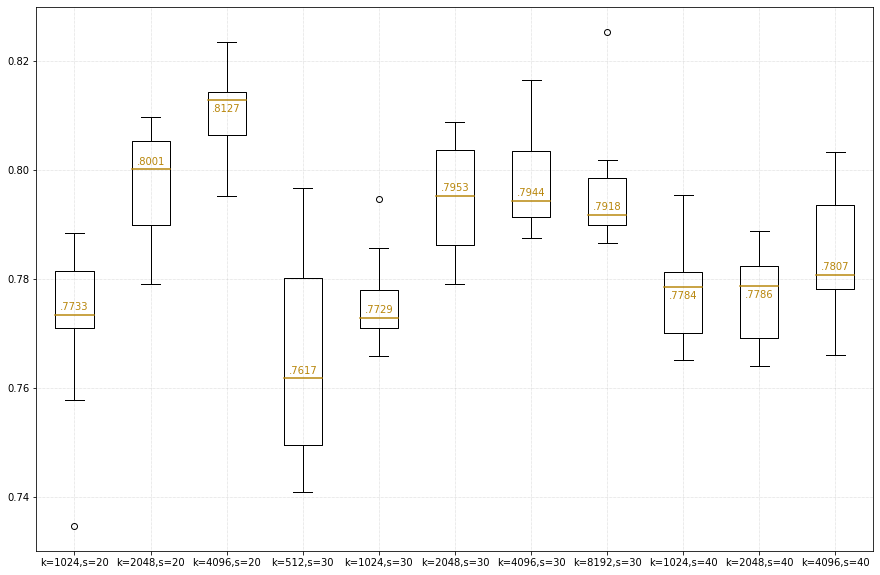

In [20]:
plot_scores(CONFIGS_BEAVER_01, beaver_01_scores, savefile="plots/approach3/boxplot_random.pdf", label_below=[2,8,9])

In [10]:
def get_elimination_rate_vals(test_labels, test_dfs, percentile=0.95):
    percentiles = []
    for i in range(test_dfs.shape[1]):
        fpr, tpr, thresholds = roc_curve(test_labels, test_dfs[:,i])
        percentiles.append(get_percentiles(fpr, tpr, thresholds, percentiles=[percentile], verbose = False)[0])
    return percentiles

beaver_01_tnr_scores = [get_elimination_rate_vals(*read_results(**config)) for config in CONFIGS_BEAVER_01]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
6

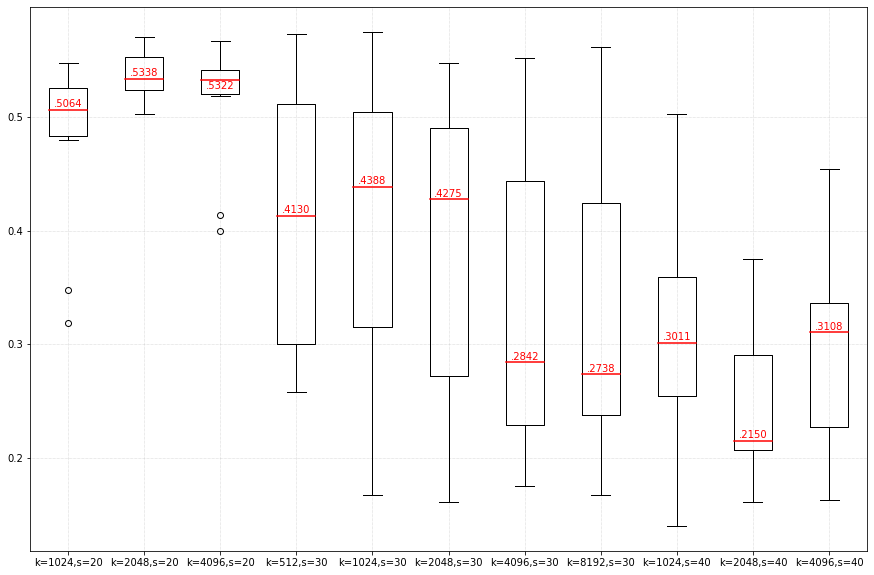

In [21]:
plot_scores(CONFIGS_BEAVER_01, beaver_01_tnr_scores, savefile="plots/approach3/boxplot_random_tnr95.pdf", label_below=[2], color="red")

### Compare sessions

In [27]:
session_scores = [get_aucs(*read_results(**config)) for config in CONFIGS_COMPARE_SESSIONS]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.
3105 test results with 3105 labels
Session 'GFox_03' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session03-VIELAAS_GFox_03
Loaded scans.
2738 test results with 2738 labels


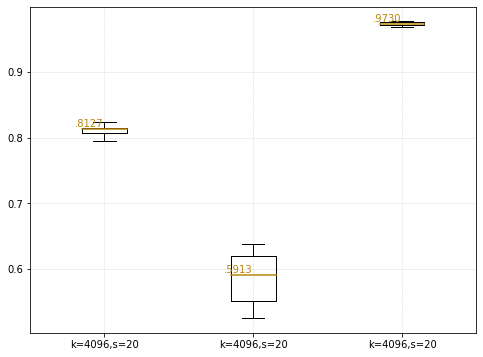

In [28]:
plot_scores(CONFIGS_COMPARE_SESSIONS, session_scores, savefile="plots/approach3/boxplot_random_sessions.pdf", figsize=(8, 6))

In [29]:
session_tnr_scores = [get_elimination_rate_vals(*read_results(**config)) for config in CONFIGS_COMPARE_SESSIONS]

Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.
695 test results with 695 labels
Session 'Marten_01' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Marten_01
Loaded scans.
3105 test results with 3105 labels
Session 'GFox_03' at folder: /home/kleinsteuber/vscode/ResizedSessions_NoBackup/VIELAAS_Spring_Session03-VIELAAS_GFox_03
Loaded scans.
2738 test results with 2738 labels


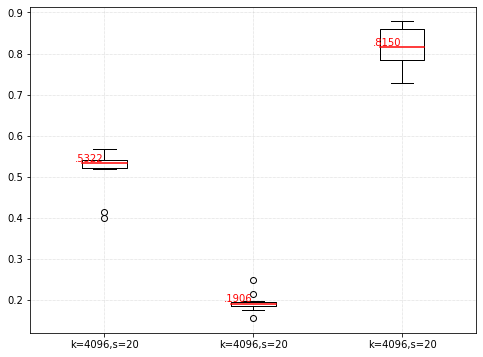

In [30]:
plot_scores(CONFIGS_COMPARE_SESSIONS, session_tnr_scores, savefile="plots/approach3/boxplot_random_sessions_tnr95.pdf", figsize=(8, 6), color="red")